In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess 
from skmisc.loess import loess
%matplotlib inline
from itertools import combinations
from itertools import chain
from itertools import product
import statsmodels

from multiprocessing import Pool
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
graphs_path = '../code/graphs.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
sys.path.append(os.path.dirname(os.path.expanduser(graphs_path)))
import tools
import graphs
from tools import mutant_colorset
from tools import condition_colorset
from tools import renamed_conditions

In [5]:
cov_thresh = 1e6

# fitness_data = p.read_csv('../data/DoubleBC_Merged_Fitness_Atish_Weighted_Default_AllConditions_IncludingOld_swapsremoved.csv')
fitness_data = p.read_csv('../data/fitness_weighted_allconditions_swapsremoved.csv')


merged_fitness_data = fitness_data

In [6]:
mutant_train_set = p.read_csv('../data/mutant_train_set.csv')
training_bcs = mutant_train_set['barcode'].values

mutant_minimal_train_set = p.read_csv('../data/mutant_minimal_train_set.csv')
minimal_training_bcs = mutant_minimal_train_set['barcode'].values

mutant_minimal_test_set = p.read_csv('../data/mutant_minimal_test_set.csv')
minimal_testing_bcs = mutant_minimal_test_set['barcode'].values

mutant_minimal_wothers_train_set = p.read_csv('../data/mutant_minimal+otheradaptive_train_set.csv')
minimal_wothers_training_bcs = mutant_minimal_wothers_train_set['barcode'].values

mutant_minimal_wothers_test_set = p.read_csv('../data/mutant_minimal+otheradaptive_test_set.csv')
minimal_wothers_testing_bcs = mutant_minimal_wothers_test_set['barcode'].values
print(len(minimal_wothers_testing_bcs))

# mutant_justothers_train_set = p.read_csv('../data/mutant_justother_train_set.csv')
# justothers_training_bcs = mutant_justothers_train_set['barcode'].values

# mutant_justothers_test_set = p.read_csv('../data/mutant_justother_test_set.csv')
# justothers_testing_bcs = mutant_justothers_test_set['barcode'].values

76


In [7]:
old_conditions = {
#                   '3':['t3.1','t3.2','t3.3'],
#                   '6':['t6.1','t6.2','t6.3'],
#                   '13':['t13.1','t13.2','t13.3'],
#                   '18':['t18.1','t18.2','t18.3'],
                  '19':['t19.1','t19.2','t19.3'],
#                   '20':['t20.1','t20.2','t20.3'],
#                   '21':['t21.1','t21.2','t21.3'],
#                   '23':['t23.1','t23.2','t23.3'],
                  'M3_Batch_3':['3.1','3.2','3.3'],
                  'M3_Batch_6':['6.1','6.2','6.3'],
                  'M3_Batch_13':['13.1','13.2','13.3'],
                  'M3_Batch_18':['18.1','18.2','18.3'],
#                   'M3_Batch_19':['t19.1','t19.2','t19.3'],
                  'M3_Batch_20':['20.1','20.2','20.3'],
                  'M3_Batch_21':['21.1','21.2','21.3'],
                  'M3_Batch_23':['23.1','23.2','23.3'],
                    ## radicicol
                    ## benomyl
                    ## fluconazole

    
    }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
                        '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MNaCl' :['K'], 
                        '1BB_0.5MNaCl' :['M','N'],
                        '1BB_0.2MKCl' :['O'],
                        '1BB_0.5MKCl' :['P'],
                        '1BB_8.5uMGdA' :['Q','R'],
                        '1BB_17uMGdA' :['S','T'],
                        '1BB_2ugFlu' :['U','V'],
                        '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
                        '1BB_1%EtOH' :['EE','FF'],
                        '1BB_SucRaf' :['GG'],
                      }



# old_nonm3_conditions = [
# #     '1.4Glucose', '1.6Glucose', '1.7Glucose', '1.8Glucose',
#        '2.5Glucose', '24_Hour_Transfer_PC', 'Benomyl_2ug/mL',
#        'DMSO', 'Ferm_40_Hour_Transfer', 'Ferm_44_Hour_Transfer',
#        'Ferm_50_Hour_Transfer', 'Ferm_54_Hour_Transfer',
#        'Fluconazole_2ug/mL', 'Geldanamycin8.5uM','Radicicol_5uM', 'Resp_5_Day_Transfer',
#        'Resp_7_Day_Transfer']

old_nonm3_conditions = {'Ferm_44hr_Transfer':['t14.1','t14.2','t14.3'],
                  'Ferm_40hr_Transfer':['t15.1','t15.2','t15.3'],
                  'Ferm_54hr_Transfer':['t16.1','t16.2','t16.3'],
                  'Ferm_50hr_Transfer':['t17.1','t17.2','t17.3'],
                  'Resp_24hr_Transfer':['t5.1','t5.2','t5.3'],
                  'Resp_3Day_Transfer':['t7.1','t7.2','t7.3'],
                  'Resp_4Day_Transfer':['t8.1','t8.2','t8.3'],
                  'Resp_5Day_Transfer':['t25.1','t25.2','t25.3'],
                  'Resp_6Day_Transfer':['t26.1','t26.2','t26.3'],
                  'Resp_7Day_Transfer':['t27.1','t27.2','t27.3'],
                  'DMSO':['t1.1','t1.2','t1.3'],
                  'Geldanamycin8.5uM':['t2.4','t2.5','t2.6'],
                    '1.4%':['1.4%-R1','1.4%-R2'],
                    '1.5%':['1.5%-R1','1.5%-R2'],
                    '1.6%':['1.6%-R1','1.6%-R2'],
                    '1.7%':['1.7%-R1','1.7%-R2'],
                    '1.8%':['1.8%-R1','1.8%-R2'],
                    '2.5%':['2.5%-R1','2.5%-R2'],  # not enough usable data
                    'Ben0.4':['Ben0.4-R1','Ben0.4-R2'], # not enough usable data
                    'Ben2':['Ben2-R1','Ben2-R2'], # not enough usable data
#                     'Ben10':['Ben10-R1','Ben10-R2'],
                       }




# m3_conditions = {**old_conditions,}
conditions = {**old_conditions, **bigbatch_conditions}
conditions = {**conditions, **old_nonm3_conditions}
all_conditions = conditions.keys()
all_reps = [rep for reps in conditions.values() for rep in reps]

m3_conditions = list(old_conditions.keys()) + ['1BB_M3']
m3_reps = [rep for condition in m3_conditions for rep in conditions[condition]]




In [8]:
full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]

# neutrals = full_neutral_list
neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))

In [9]:
this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
# this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

m3_cols = [col + '_fitness' for col in m3_conditions]
m3_conditions = m3_cols

nonm3_cols = [col + '_fitness' for col in bigbatch_conditions.keys() if (col + '_fitness') not in m3_cols]
nonm3_cols = nonm3_cols + [col + '_fitness' for col in old_nonm3_conditions.keys()]
nonm3_conditions = nonm3_cols

fitness_cols = m3_cols + nonm3_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]



([<matplotlib.axis.YTick at 0x109262550>,
 <a list of 6 Text yticklabel objects>)

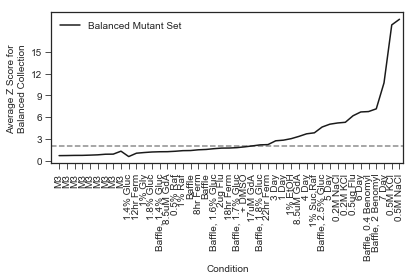

In [10]:
used_mutants = [bc for bc in this_data['barcode'].values if bc in (list(minimal_wothers_training_bcs) + list(minimal_wothers_testing_bcs))]
# used_mutants = [bc for bc in this_data['barcode'].values]

all_mut_locs = sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))

counts = np.unique(this_data['mutation_type'].values[all_mut_locs],return_counts=True)

like_mutant_count_dict = {mut_type:count for mut_type,count in zip(*counts)}

like_mutant_count = [like_mutant_count_dict[mut_type] for mut_type in this_data['mutation_type'].values[all_mut_locs]]
like_mutant_count_m3 = np.repeat(like_mutant_count,len(m3_cols)).reshape(len(like_mutant_count),len(m3_cols))
like_mutant_count_nonm3 = np.repeat(like_mutant_count,len(nonm3_cols)).reshape(len(like_mutant_count),len(nonm3_cols))     
# rel_mutant_count_m3 = 

m3_means = np.nanmean(this_data[m3_cols].values[all_mut_locs,:],axis=1)
m3_stds = np.nanstd(this_data[m3_cols].values[all_mut_locs,:],axis=1)

repeated_means = np.repeat(m3_means,len(nonm3_cols)).reshape(len(m3_means),len(nonm3_cols))
repeated_stds = np.repeat(m3_stds,len(nonm3_cols)).reshape(len(m3_stds),len(nonm3_cols))
nonm3_z_scores = np.abs((this_data[nonm3_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

repeated_means = np.repeat(m3_means,len(m3_cols)).reshape(len(m3_means),len(m3_cols))
repeated_stds = np.repeat(m3_stds,len(m3_cols)).reshape(len(m3_stds),len(m3_cols))
m3_z_scores = np.abs((this_data[m3_cols].values[all_mut_locs,:]-repeated_means)/repeated_stds)

mean_m3_z_scores = np.sum(m3_z_scores/like_mutant_count_m3,axis=0)/len(counts[0])
mean_nonm3_z_scores = np.sum(nonm3_z_scores/like_mutant_count_nonm3,axis=0)/len(counts[0])

plt.figure()

sorted_nonm3_cols = np.asarray(nonm3_cols)[np.argsort(np.sum(nonm3_z_scores/like_mutant_count_nonm3,axis=0)/len(counts[0]))]
sorted_m3_cols = np.asarray(m3_cols)[np.argsort(np.sum(m3_z_scores/like_mutant_count_m3,axis=0)/len(counts[0]))]

sorted_mean_m3_z_scores = sorted(np.sum(m3_z_scores/like_mutant_count_m3,axis=0)/len(counts[0]))
sorted_mean_nonm3_z_scores = sorted(np.sum(nonm3_z_scores/like_mutant_count_nonm3,axis=0)/len(counts[0]))

plt.plot(sorted_mean_m3_z_scores+sorted_mean_nonm3_z_scores,'-',color='k',alpha=1.0,label='Balanced Mutant Set')

all_cols = list(sorted_m3_cols)+list(sorted_nonm3_cols)
plt.xticks(range(len(all_cols)),[renamed_conditions[col.split('_fitness')[0]] for col in (all_cols)],rotation=90)


plt.legend()
# plt.ylim(0,7)
plt.xlim(-1,len(m3_conditions)+len(nonm3_conditions)-0.5)
plt.ylabel('Average Z Score for\nBalanced Collection')
plt.xlabel('Condition')

plt.tight_layout()
plt.axhline(2,color='k',linestyle='--',alpha=0.5)
plt.yticks(range(0,16,3),range(0,16,3))
# plt.savefig('z_scores_minimal_comparison.pdf',bbox_inches='tight')

In [11]:
# last_subtle = 17
first_nonsubtle = np.where(np.asarray(sorted_mean_nonm3_z_scores) > 2.0)[0][0]
print('subtle: ',list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle]))
print('strong: ',list(sorted_nonm3_cols[first_nonsubtle:]))

this_data = merged_fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()
this_data = this_data.sort_values('barcode')

datasets = {}

gene_list = ['IRA1_nonsense','GPB2','PDE2','Diploid','ExpNeutral']

# datasets['subtle_to_strong_wothers'] = tools.situate_data(this_data,list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle]),list(sorted_nonm3_cols[first_nonsubtle:]),
#                   minimal_wothers_training_bcs,minimal_wothers_testing_bcs,gene_list)
datasets['subtle_to_strong_wothers_fixed_mutants'] = tools.situate_data(this_data,list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle]),list(sorted_nonm3_cols[first_nonsubtle:]),
                  minimal_wothers_training_bcs,minimal_wothers_testing_bcs,gene_list,fixed_mutant_sets=True)




subtle:  ['M3_Batch_23_fitness', 'M3_Batch_6_fitness', 'M3_Batch_18_fitness', 'M3_Batch_3_fitness', 'M3_Batch_20_fitness', 'M3_Batch_13_fitness', '19_fitness', '1BB_M3_fitness', 'M3_Batch_21_fitness', '1BB_1.4%Gluc_fitness', 'Ferm_44hr_Transfer_fitness', '1BB_1%Gly_fitness', '1BB_1.8%Gluc_fitness', '1.4%_fitness', 'Geldanamycin8.5uM_fitness', '1BB_0.5%Raf_fitness', '1BB_1%Raf_fitness', '1.5%_fitness', 'Ferm_40hr_Transfer_fitness', '1BB_Baffle_fitness', '1.6%_fitness', '1BB_2ugFlu_fitness', 'Ferm_50hr_Transfer_fitness', '1.7%_fitness', 'DMSO_fitness']
strong:  ['1BB_17uMGdA_fitness', '1.8%_fitness', 'Ferm_54hr_Transfer_fitness', 'Resp_3Day_Transfer_fitness', 'Resp_24hr_Transfer_fitness', '1BB_1%EtOH_fitness', '1BB_8.5uMGdA_fitness', 'Resp_4Day_Transfer_fitness', '1BB_SucRaf_fitness', '2.5%_fitness', 'Resp_5Day_Transfer_fitness', '1BB_0.2MNaCl_fitness', '1BB_0.2MKCl_fitness', '1BB_0.5ugFlu_fitness', 'Resp_6Day_Transfer_fitness', 'Ben0.4_fitness', 'Ben2_fitness', 'Resp_7Day_Transfer_fitne

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


1 0.5059630450118833
2 0.720914688061188
3 0.7218324352679876
4 0.7078893156633462
5 0.6910012819923146
6 0.7089221529651355
7 0.7291859055778047
8 0.7823171944752093
9 0.7883347004443251
10 0.759307752672688
11 0.7552700876697782
12 0.7521061736885813
13 0.7391640115573719
14 0.7409404538136157
15 0.7539421203447269
16 0.745985104130915
17 0.7618703193637425
18 0.7505280405948825
19 0.7392601432232723
20 0.720524725553906
21 0.7208185491547798
22 0.7019016290016626
23 0.6743507824893442
24 0.6681773843011426
25 0.447427576929617


In [12]:
model = 8

mutant_locs = datasets['subtle_to_strong_wothers_fixed_mutants']['mut_locs'][model-1]
condition_locs = datasets['subtle_to_strong_wothers_fixed_mutants']['cond_locs'][model-1]

all_conditions = list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle]) + list(sorted_nonm3_cols[first_nonsubtle:])

subtle = list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle])

train_m = datasets['subtle_to_strong_wothers_fixed_mutants']['train'][1]

mutant_locs = mutant_locs[train_m,:]
condition_locs = condition_locs[:len(subtle)]

In [13]:
mutant_locs.shape
condition_locs.shape

(25, 8)

In [14]:
data = this_data[this_data['barcode'].isin(list(minimal_wothers_training_bcs))]
this_error = data[[col.replace('_fitness','_error') for col in subtle]].values
this_fitness = data[[col for col in subtle]].values

0.0005257116969838376 0.00040692480120707776 0.7740455529936368
8


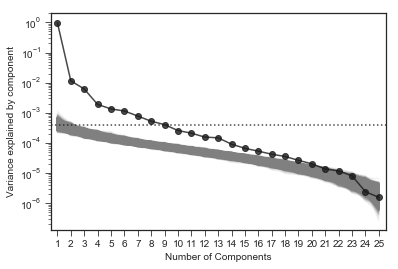

In [15]:
ax = plt.subplot(111)

tools.svd_noise_comparison_figure(ax,this_fitness,this_error,10000,yscale='log')

In [150]:
new_component = model-1
n_new_components = 1
scale_factors = np.linspace(0.5,1.0,11)
# scale_factors = [1.0,10.0,100.0]
n_iterations = 100

data = this_data[this_data['barcode'].isin(used_mutants)]
this_error = data[[col.replace('_fitness','_error') for col in subtle]].values[train_m,:]
this_fitness = data[[col for col in subtle]].values[train_m,:]

n_detected = {}

for scale_factor in scale_factors:
    n_detected[scale_factor] =[]
    for iteration in range(n_iterations):

        mutant_new_components = [np.random.permutation(mutant_locs[:,new_component]) for i in range(n_new_components)]
        condition_new_components = [scale_factor*np.random.permutation(condition_locs[:,new_component])  for i in range(n_new_components)]

        new_m_locs = np.append(mutant_locs,np.asarray(mutant_new_components).swapaxes(0,1),axis=1)
        new_c_locs = np.append(condition_locs,np.asarray(condition_new_components).swapaxes(0,1),axis=1)

        new_fitness = np.dot(new_m_locs,new_c_locs.T)

        error_pull = np.random.normal(0,this_error)

        new_w_noise = new_fitness + error_pull

        max_detected = tools.svd_noise_comparison_detection(new_w_noise,this_error,100)
        n_detected[scale_factor].append(max_detected)

fracs = {}

for scale_factor in scale_factors:
      
    this_set = np.unique(n_detected[scale_factor],return_counts=True)
    print(this_set)
    this_dict = {d:count for d,count in zip(this_set[0],this_set[1])}
    if model+n_new_components not in this_dict.keys():
        this_dict[model+n_new_components] = 0
    print(this_dict)
    total = np.sum(this_set[1])
    print(total)
    frac = this_dict[model+n_new_components]/total
    print(model+n_new_components)
    print(frac)
    fracs[scale_factor] = frac

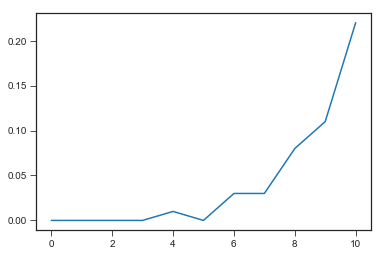

In [152]:
plt.plot(fracs.values())

[0.8136159899409312, 0.9037666913551748, 0.9521775238342323, 0.9670600366632073, 0.9776038380913612, 0.9865823212981021, 0.9927048899374116, 0.9968170222613411, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


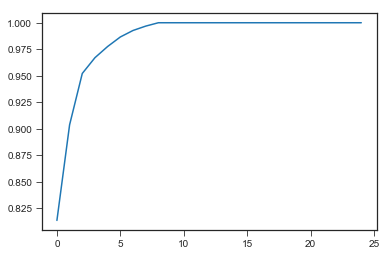

In [136]:
print(tools.SVD_fits(np.dot(mutant_locs,condition_locs.T))[0])
plt.plot(tools.SVD_fits(np.dot(mutant_locs,condition_locs.T))[0])

[21.50862704  2.33845996  1.71362843  0.95013106  0.79973111  0.73798387
  0.6094137   0.49943494  0.43940216  0.35000579  0.31689931  0.27272601
  0.26504691  0.20805814  0.17744958  0.15932459  0.14177701  0.13002361
  0.11212975  0.09832738  0.08065381  0.07478637  0.06198248  0.03385196
  0.02727016]
(36, 36)
(25, 25)
[30.98572886  6.462912    2.00853771  1.5876693   0.92331108  0.842248
  0.72754539  0.62872505  0.51888315  0.25487789  0.2307982   0.20832596
  0.19303469  0.17335314  0.14671772  0.12556322  0.12190665  0.1076806
  0.10432429  0.09050787  0.07510293  0.06415983  0.05629217  0.04991311
  0.03943253]
[21.57891123  2.54476808  2.18459421  1.57229913  0.9906921   0.85323186
  0.73586902  0.57652245  0.4999004   0.28198076  0.22287579  0.21049616
  0.17205102  0.16455244  0.15718089  0.14261739  0.1389748   0.11692823
  0.09693493  0.08519267  0.08196564  0.06663012  0.05184432  0.04104323
  0.03314821]
[21.51223952  2.29535714  1.81112262  1.60731644  0.96515285  0.793

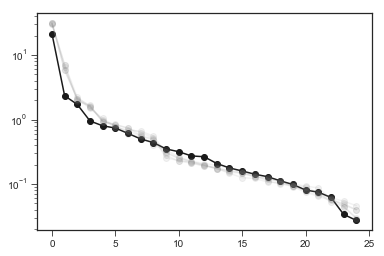

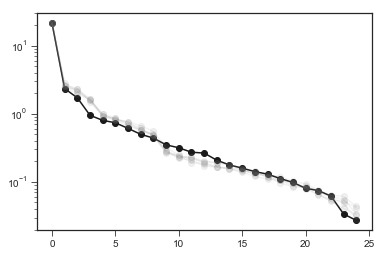

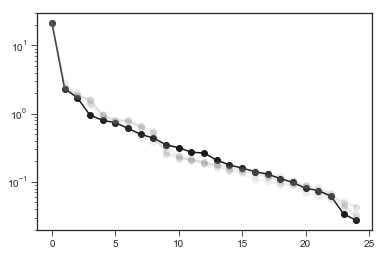

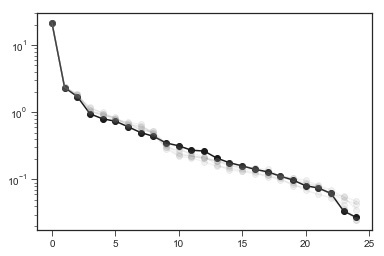

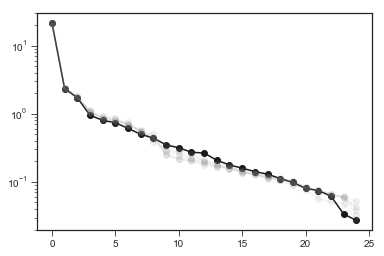

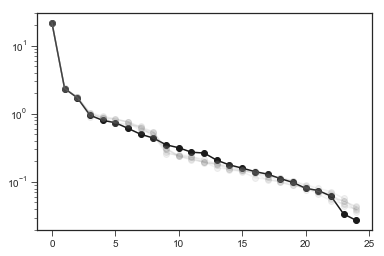

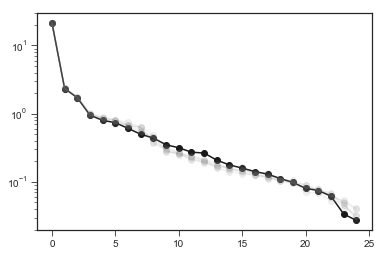

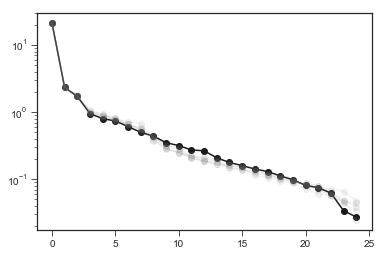

In [17]:
model = 8

new_components = range(model)
# new_components = [0]
n_new_components = 1
n_iterations = 5



data = this_data[this_data['barcode'].isin(used_mutants)]
this_error = data[[col.replace('_fitness','_error') for col in subtle]].values[train_m,:]
this_fitness = data[[col for col in subtle]].values[train_m,:]

n_detected = {}

U,s,V = np.linalg.svd(this_fitness)

print(s)
print(U.shape)
print(V.shape)

mutant_locs = U[:,:model]
condition_locs = V[:model,:].T
old_s = np.diag(s[:model])

a = 2

for new_component in new_components:
    n_detected[new_component] =[]
    plt.figure()
    plt.plot(s,marker='o',color='k')
    for iteration in range(n_iterations):
        
#         print(np.mean(U[:,new_component]))
#         print(np.std(U[:,new_component]))
        
#         mutant_new_components = [np.random.normal(np.mean(U[:,new_component]),a*np.std(U[:,new_component]),size=len(U[:,new_component])) for i in range(n_new_components)]
#         condition_new_components = [np.random.normal(np.mean(V[:,new_component]),a*np.std(V[:,new_component]),size=len(V[:,new_component])) for i in range(n_new_components)]
        mutant_new_components = [np.random.permutation(U[:,new_component]) for i in range(n_new_components)]
        condition_new_components = [np.random.permutation(V[:,new_component]) for i in range(n_new_components)]
        
        new_m_locs = np.append(mutant_locs,np.asarray(mutant_new_components).swapaxes(0,1),axis=1)
        new_c_locs = np.append(condition_locs,np.asarray(condition_new_components).swapaxes(0,1),axis=1)
        new_s = np.diag(np.append(s[:model],[s[new_component] for i in range(n_new_components)]))
        
        new_fitness = np.dot(np.dot(new_m_locs,new_s),new_c_locs.T)

        error_pull = np.random.normal(0,this_error)

        new_w_noise = new_fitness + error_pull
        
        this_u,this_s,this_v = np.linalg.svd(new_w_noise)
#         print(this_s)
        plt.plot(this_s,marker='o',color='gray',alpha=0.1)
        
        
        

        max_detected = tools.svd_noise_comparison_detection(new_w_noise,this_error,100)
        n_detected[new_component].append(max_detected)
    plt.yscale('log')
    print(this_s)

# fracs = {}

# for new_component in new_components:
      
#     this_set = np.unique(n_detected[new_component],return_counts=True)
#     print(this_set)
#     this_dict = {d:count for d,count in zip(this_set[0],this_set[1])}
#     if model+n_new_components not in this_dict.keys():
#         this_dict[model+n_new_components] = 0
#     print(this_dict)
#     total = np.sum(this_set[1])
#     print(total)
#     frac = this_dict[model+n_new_components]/total
#     print(model+n_new_components)
#     print(frac)
#     fracs[new_component] = frac

7
0.25790945360393375
0.37435921585821963
0.17031672293427702
0.09298355926637572
0.018227517156356347
0.09905089346745832
0.28555221319708335
0.10854314637255442

0.15143268842391772


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0.16458958863221326

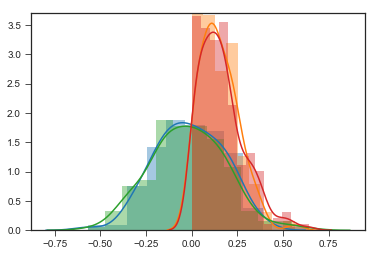

In [23]:
corrs = []

print(new_component)

for i in range(100):

    corrs.append(np.corrcoef(U[:,new_component],np.random.permutation(U[:,new_component]))[0,1])
    
this_perm = np.random.permutation(U[:,new_component])
for i in range(model):
    print(np.abs(np.corrcoef(U[:,i],this_perm)[0,1]))
    
sns.distplot(corrs)
sns.distplot(np.abs(corrs))
print( )
print(np.mean(np.abs(corrs)))

for i in range(100):

    corrs.append(np.corrcoef(V[:,new_component],np.random.permutation(V[:,new_component]))[0,1])
    
sns.distplot(corrs)
sns.distplot(np.abs(corrs))
np.mean(np.abs(corrs))

In [ ]:
fracs = {}

for new_component in new_components:
    print(new_component)
    this_set = np.unique(n_detected[new_component],return_counts=True)
    print(this_set)
    this_dict = {d:count for d,count in zip(this_set[0],this_set[1])}
    if model+n_new_components not in this_dict.keys():
        this_dict[model+n_new_components] = 0
    print(this_dict)
    total = np.sum(this_set[1])
    print(total)
    frac = this_dict[model+n_new_components]/total
    print(model+n_new_components)
    print(frac)
    fracs[new_component] = frac

In [ ]:
plt.plot(fracs.values())

0.0004261454081914623 0.00013921147230407563 0.3266759881207719
9
0.0005606597093178958 0.00019574988592717995 0.34914206010153864
8
0.0005257116969838376 0.00040692480120707776 0.7740455529936368
8


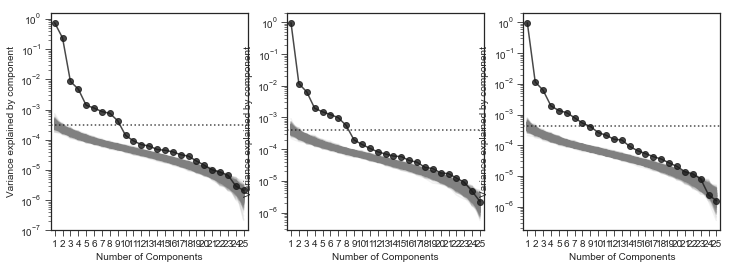

In [85]:
plt.figure(figsize=(12,4))

ax = plt.subplot(131)

tools.svd_noise_comparison_figure(ax,new_w_noise,this_error,1000,yscale='log')

ax = plt.subplot(132)

old_w_noise = np.dot(np.dot(mutant_locs,old_s),condition_locs.T) + error_pull

tools.svd_noise_comparison_figure(ax,old_w_noise,this_error,1000,yscale='log')

ax = plt.subplot(133)

# old_w_noise = this_fitness + error_pull

tools.svd_noise_comparison_figure(ax,this_fitness,this_error,1000,yscale='log')

In [80]:
new_s

array([[21.50862704,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  2.33845996,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.71362843,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.95013106,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.79973111,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.73798387,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.6094137 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0